#  Customer Churn Prediction Project
## Music Streaming Service User Retention Analysis

**Objective:** Predict user churn (cancellation) within a 10-day window  
**Best Score:** 0.69016 (Kaggle Competition)

---

##  Table of Contents

1. [Problem Statement](#problem-statement)
2. [Data Understanding](#data-understanding)
3. [Feature Engineering](#feature-engineering)
4. [Model Development](#model-development)
5. [Results & Analysis](#results--analysis)
6. [Conclusion](#conclusion)

---

##  Problem Statement

### The Challenge

We are tasked with predicting which users of a music streaming service will **churn** (cancel their subscription) within a 10-day window following November 20, 2018.

### Key Challenges

- **Severe Class Imbalance**: Only ~3.5% of users churn in the training set
- **Distribution Shift**: Test set is artificially balanced to ~50% churn rate
- **Temporal Constraint**: Must use only data before the prediction cutoff date
- **Data Leakage Risk**: Must avoid using future information (e.g., "Cancellation Confirmation" page)

### Solution Approach

Instead of treating this as a standard classification problem, we reframed it as a **ranking problem**. Our goal is to learn a scoring function that ranks users by their churn risk, regardless of the absolute probability calibration. This makes **AUC (Area Under the ROC Curve)** the primary validation metric.


## Section 1: Imports and Configuration


In [39]:
import pandas as pd
import numpy as np
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from scipy.stats import rankdata

try:
    import lightgbm as lgb
    HAS_LIGHTGBM = True
except ImportError:
    HAS_LIGHTGBM = False

try:
    from catboost import CatBoostClassifier
    HAS_CATBOOST = True
except ImportError:
    HAS_CATBOOST = False

try:
    import xgboost as xgb
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False

print(f" Libraries loaded: LightGBM={HAS_LIGHTGBM}, CatBoost={HAS_CATBOOST}, XGBoost={HAS_XGBOOST}")

# Configuration
FINAL_CUTOFF = pd.Timestamp('2018-11-20')
CHURN_WINDOW = 10
LEAKY_PAGES = ['Cancellation Confirmation']  # Must exclude from features!

# Multi-Window Training Strategy 
TRAINING_WINDOWS = [
    {'cutoff': pd.Timestamp('2018-10-20'), 'name': 'Window1_Oct20'},
    {'cutoff': pd.Timestamp('2018-10-30'), 'name': 'Window2_Oct30'},
    {'cutoff': pd.Timestamp('2018-11-10'), 'name': 'Window3_Nov10'},
]

print(f"\n Timeline Configuration:")
print(f"   Training Windows: {len(TRAINING_WINDOWS)} snapshots")
print(f"   Final Cutoff: {FINAL_CUTOFF.date()}")
print(f"   Churn Window: {CHURN_WINDOW} days")


 Libraries loaded: LightGBM=True, CatBoost=True, XGBoost=True

 Timeline Configuration:
   Training Windows: 3 snapshots
   Final Cutoff: 2018-11-20
   Churn Window: 10 days


## Section 2: Data Understanding


In [40]:
print(" Loading data : ")
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')
all_data = pd.concat([train, test], ignore_index=True)

print(f"\n Dataset Overview:")
print(f"   Training events: {len(train):,}")
print(f"   Test events: {len(test):,}")
print(f"   Total events: {len(all_data):,}")
print(f"   Unique users (train): {train['userId'].nunique():,}")
print(f"   Unique users (test): {test['userId'].nunique():,}")

# Check date ranges
print(f"\n Date Ranges:")
print(f"   Training: {train['time'].min()} to {train['time'].max()}")
print(f"   Test: {test['time'].min()} to {test['time'].max()}")

# Overall Churn Statistics (all churners in training data)
churned_users_all = train[train['page'] == 'Cancellation Confirmation']['userId'].unique()
total_users_train = train['userId'].nunique()
overall_churn_rate = len(churned_users_all) / total_users_train * 100

print(f"\n Churn Statistics (Training Data):")
print(f"   Total users: {total_users_train:,}")
print(f"   Churned users: {len(churned_users_all):,}")
print(f"   Overall churn rate: {overall_churn_rate:.2f}%")

# Test users to predict
test_user_ids = test['userId'].unique()
print(f"\n Test Users to Predict: {len(test_user_ids):,}")
print(f"   Note: Test set is artificially balanced to ~50% churn")


 Loading data : 

 Dataset Overview:
   Training events: 17,499,636
   Test events: 4,393,179
   Total events: 21,892,815
   Unique users (train): 19,140
   Unique users (test): 2,904

 Date Ranges:
   Training: 2018-10-01 00:00:01 to 2018-11-20 00:00:00
   Test: 2018-10-01 00:00:06 to 2018-11-20 00:00:00

 Churn Statistics (Training Data):
   Total users: 19,140
   Churned users: 4,271
   Overall churn rate: 22.31%

 Test Users to Predict: 2,904
   Note: Test set is artificially balanced to ~50% churn


### Exploratory Data Analysis (EDA)

Before diving into feature engineering, let's understand the user behavior and churn patterns. We'll look at:
1. **Churn by Categorical Variables** (Gender, Subscription Level)
2. **User History Length** (How long users stay before churning)
3. **Activity Patterns** (Engagement levels)

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare User-Level EDA Data
# We use the same churn definition as above for the EDA snapshot
eda_cutoff = pd.Timestamp('2018-11-10')
eda_churn_window_end = eda_cutoff + timedelta(days=CHURN_WINDOW)

# Identify churners
eda_churned_users = all_data[
    (all_data['time'] > eda_cutoff) & 
    (all_data['time'] <= eda_churn_window_end) &
    (all_data['page'] == 'Cancellation Confirmation')
]['userId'].unique()

# Filter data to cutoff for feature calculation
eda_data = all_data[all_data['time'] <= eda_cutoff].copy()

# Get user-level metadata
user_meta = eda_data.sort_values('time').groupby('userId').agg({
    'gender': 'last',
    'level': 'last',
    'time': ['min', 'max'],
    'page': 'count',
    'song': 'count'
})

user_meta.columns = ['gender', 'level', 'first_active', 'last_active', 'total_events', 'total_songs']
user_meta = user_meta.reset_index()

# Add churn label
user_meta['is_churned'] = user_meta['userId'].isin(eda_churned_users).astype(int)
user_meta['history_length_days'] = (user_meta['last_active'] - user_meta['first_active']).dt.days
user_meta['avg_daily_events'] = user_meta['total_events'] / (user_meta['history_length_days'] + 1)

print(f"EDA Dataset: {len(user_meta)} users")
print(f"Churn Rate 10 day window: {user_meta['is_churned'].mean():.2%}")

EDA Dataset: 21762 users
Churn Rate 10 day window: 3.05%


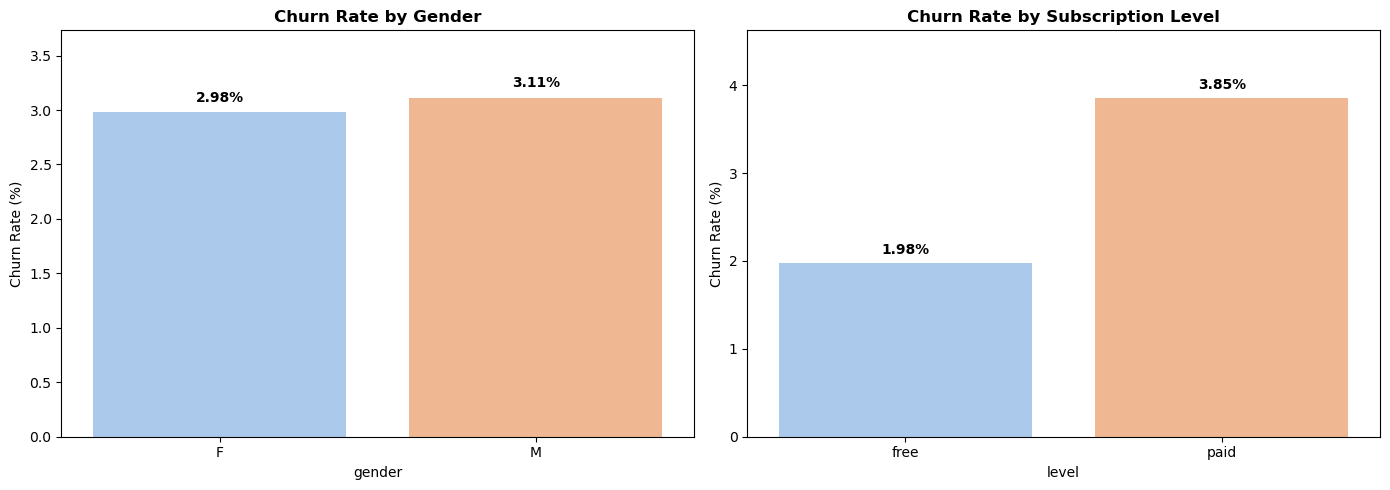

In [43]:
# 2. Churn Rate by Categorical Variables
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gender
gender_churn = user_meta.groupby('gender')['is_churned'].mean() * 100
sns.barplot(x=gender_churn.index, y=gender_churn.values, ax=axes[0], palette='pastel')
axes[0].set_title('Churn Rate by Gender', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Churn Rate (%)')
axes[0].set_ylim(0, max(gender_churn.values) * 1.2)
for i, v in enumerate(gender_churn.values):
    axes[0].text(i, v + 0.1, f'{v:.2f}%', ha='center', fontweight='bold')

# Paid vs Free
level_churn = user_meta.groupby('level')['is_churned'].mean() * 100
sns.barplot(x=level_churn.index, y=level_churn.values, ax=axes[1], palette='pastel')
axes[1].set_title('Churn Rate by Subscription Level', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Churn Rate (%)')
axes[1].set_ylim(0, max(level_churn.values) * 1.2)
for i, v in enumerate(level_churn.values):
    axes[1].text(i, v + 0.1, f'{v:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

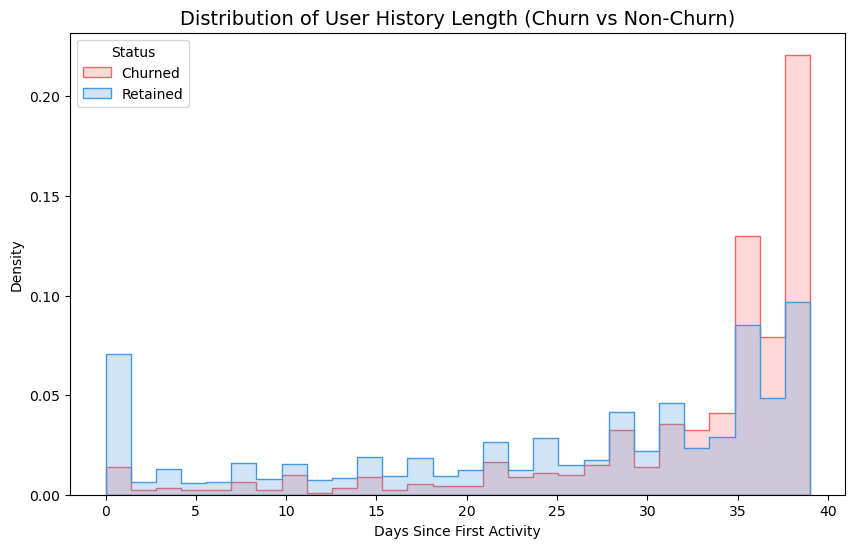

Median History Length:
is_churned
0    29.0
1    36.0
Name: history_length_days, dtype: float64


In [44]:
# 3. Check History Length : Days Active
plt.figure(figsize=(10, 6))
sns.histplot(data=user_meta, x='history_length_days', hue='is_churned', 
             element='step', stat='density', common_norm=False, palette=['#4299e1', '#f56565'])
plt.title('Distribution of User History Length (Churn vs Non-Churn)', fontsize=14)
plt.xlabel('Days Since First Activity')
plt.legend(title='Status', labels=['Churned', 'Retained'])
plt.show()

print("Median History Length:")
print(user_meta.groupby('is_churned')['history_length_days'].median())

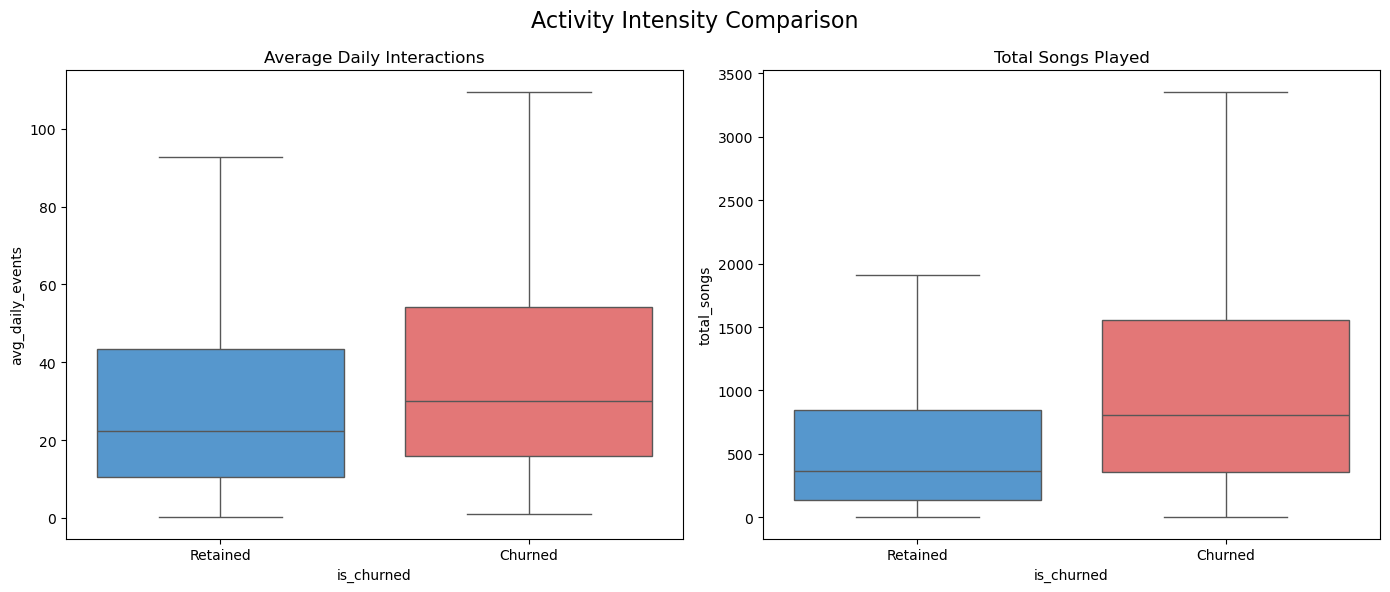

In [45]:
# 4. User Behavior & Activity Intensity
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Average Daily Events
sns.boxplot(x='is_churned', y='avg_daily_events', data=user_meta, ax=axes[0], palette=['#4299e1', '#f56565'], showfliers=False)
axes[0].set_title('Average Daily Interactions', fontsize=12)
axes[0].set_xticklabels(['Retained', 'Churned'])

# Total Songs Played
sns.boxplot(x='is_churned', y='total_songs', data=user_meta, ax=axes[1], palette=['#4299e1', '#f56565'], showfliers=False)
axes[1].set_title('Total Songs Played', fontsize=12)
axes[1].set_xticklabels(['Retained', 'Churned'])

plt.suptitle('Activity Intensity Comparison', fontsize=16)
plt.tight_layout()
plt.show()

## Section 3: Feature Engineering


The key insight is that **raw counts are biased by user tenure**. A user who has been active for 6 months but stopped listening 2 weeks ago will still have higher total counts than a highly active new user. Instead of looking at absolute values (integral of behavior), we focus on the **rate of change** (derivative of behavior). We create ratio features comparing recent activity to historical baselines.

### Feature Categories

1. **Basic Aggregations**: Sessions, interactions, songs played, listening time
2. **Temporal Features**: Days active, days since last activity, activity trends
3. **Trend Features** (Key Innovation): Recent activity vs. historical average
4. **Frustration Signals**: Error rates, advertisement frequency, thumbs down rates
5. **Engagement Metrics**: Social interactions, playlist additions
6. **Composite Risk Score**: Weighted combination of high-risk behaviors


In [46]:
def create_features(df, cutoff_date, user_list=None):
    """
    Create comprehensive feature set from user activity logs.
    
    Key Innovation: Trend-based features that capture behavioral changes
    rather than absolute counts.
    """
    df_filtered = df[df['time'] <= cutoff_date].copy()
    if user_list is not None:
        df_filtered = df_filtered[df_filtered['userId'].isin(user_list)]
    
    if len(df_filtered) == 0: 
        return pd.DataFrame()
    
    # 1. Basic Aggregations
    user_features = df_filtered.groupby('userId').agg({
        'sessionId': 'nunique',
        'page': 'count',
        'song': lambda x: x.notna().sum(),
        'length': ['mean', 'sum', 'std'],
        'time': ['min', 'max'],
        'artist': 'nunique',
    }).reset_index()
    
    user_features.columns = ['userId', 'num_sessions', 'total_interactions', 
                             'songs_played', 'avg_song_length', 'total_listening_time', 'std_song_length',
                             'first_activity', 'last_activity', 'unique_artists']
    
    # 2. Temporal & Loyalty Features
    user_features['days_active'] = (user_features['last_activity'] - user_features['first_activity']).dt.days + 1
    user_features['days_since_last_activity'] = (cutoff_date - user_features['last_activity']).dt.days
    
    # 3. Intensity Metrics
    user_features['interactions_per_session'] = user_features['total_interactions'] / user_features['num_sessions'].clip(lower=1)
    user_features['songs_per_minute'] = user_features['songs_played'] / (user_features['total_listening_time'] / 60 + 0.1)
    
    # Engagement Depth Features
    user_features['unique_artists_ratio'] = user_features['unique_artists'] / user_features['songs_played'].clip(lower=1)
    user_features['listen_time_per_song'] = user_features['total_listening_time'] / user_features['songs_played'].clip(lower=1)
    
    # 4. Recent Activity Trends (THE KEY INNOVATION!)
    for window in [7, 14]:
        recent = df_filtered[df_filtered['time'] >= cutoff_date - timedelta(days=window)]
        recent_agg = recent.groupby('userId').agg({
            'page': 'count', 
            'song': lambda x: x.notna().sum()
        }).reset_index()
        recent_agg.columns = ['userId', f'recent_{window}d_interactions', f'recent_{window}d_songs']
        user_features = user_features.merge(recent_agg, on='userId', how='left').fillna(0)
    
    # Trend Ratio: Recent activity vs. historical average
    avg_daily_interactions = user_features['total_interactions'] / user_features['days_active'].clip(lower=1)
    user_features['trend_7d'] = (user_features['recent_7d_interactions'] / 7) / (avg_daily_interactions + 0.01)
    
    # 5. Frustration & Annoyance Features
    df_no_leak = df_filtered[~df_filtered['page'].isin(LEAKY_PAGES)]
    key_pages = ['Thumbs Down', 'Thumbs Up', 'Roll Advert', 'Error', 'Help', 
                 'Add Friend', 'Downgrade', 'Cancel', 'Add to Playlist']
    
    for page in key_pages:
        count = df_no_leak[df_no_leak['page'] == page].groupby('userId').size().reset_index(
            name=f'count_{page.replace(" ", "_")}')
        user_features = user_features.merge(count, on='userId', how='left').fillna(0)
    
    # Derived Frustration Metrics
    user_features['error_rate'] = user_features['count_Error'] / user_features['total_interactions'].clip(lower=1)
    user_features['advert_rate'] = user_features['count_Roll_Advert'] / user_features['songs_played'].clip(lower=1)
    user_features['thumbs_down_rate'] = user_features['count_Thumbs_Down'] / user_features['songs_played'].clip(lower=1)
    user_features['thumbs_up_rate'] = user_features['count_Thumbs_Up'] / user_features['songs_played'].clip(lower=1)
    user_features['satisfaction_ratio'] = user_features['count_Thumbs_Up'] / (user_features['count_Thumbs_Down'] + 1)
    
    # Social & Investment Engagement
    user_features['add_friend_rate'] = user_features['count_Add_Friend'] / user_features['total_interactions'].clip(lower=1)
    user_features['playlist_add_rate'] = user_features['count_Add_to_Playlist'] / user_features['songs_played'].clip(lower=1)
    
    # 6. Intent Signals
    user_features['cancel_intent'] = (user_features['count_Cancel'] > 0).astype(int)
    
    # 7. Demographics
    level_df = df_filtered.sort_values('time').groupby('userId')['level'].last().reset_index()
    user_features = user_features.merge(level_df, on='userId', how='left')
    user_features['is_paid'] = (user_features['level'] == 'paid').astype(int)
    
    gender_df = df_filtered.groupby('userId')['gender'].first().reset_index()
    user_features = user_features.merge(gender_df, on='userId', how='left')
    user_features['is_male'] = (user_features['gender'] == 'M').astype(int)

    # 8. COMPOSITE RISK SCORE (Domain-Driven Heuristic)
    user_features['risk_score'] = (
        user_features['cancel_intent'] * 5 + 
        (user_features['trend_7d'] < 0.5).astype(int) * 3 +
        (user_features['error_rate'] > 0.01).astype(int) * 2 +
        (user_features['days_since_last_activity'] > 3).astype(int) * 2
    )
    
    # 9. Surgical Cleaning (Remove only perfect duplicates/metadata)
    drop_cols = [
        'first_activity', 'last_activity', 'level', 'gender',  # Metadata
        'songs_played',          # 99.9% correlated with total_interactions
        'total_listening_time',  # 99.8% correlated with total_interactions
        'recent_7d_songs',       # 99.8% correlated with recent_7d_interactions
        'recent_14d_songs',      # 99.9% correlated with recent_14d_interactions
        'count_Cancel',          # 100% correlated with cancel_intent
    ]
    
    cols_to_drop = [c for c in drop_cols if c in user_features.columns]
    user_features = user_features.drop(columns=cols_to_drop)
    
    return user_features.fillna(0)

print(" Feature engineering function defined")


 Feature engineering function defined


### Multi-Window Training Data Creation

Instead of training on a single snapshot, we create **three distinct training windows** to:
- **Triple the training volume** without synthetic data
- **Capture churn patterns** at different stages of the user lifecycle
- **Improve generalization** by learning from diverse behavioral trajectories


In [47]:
def get_churned_users(df, cutoff_date, churn_window=10):
    """Identify users who churned within the churn window after cutoff."""
    churn_end = cutoff_date + timedelta(days=churn_window)
    churn_period = df[(df['time'] > cutoff_date) & (df['time'] <= churn_end)]
    return churn_period[churn_period['page'] == 'Cancellation Confirmation']['userId'].unique()

# Create multi-window training data
print(" Creating Multi-Window Training Data...")
all_train_features = []

for w in TRAINING_WINDOWS:
    cutoff = w['cutoff']
    print(f"  Processing {w['name']} (cutoff: {cutoff.date()})...")
    
    users = all_data[all_data['time'] <= cutoff]['userId'].unique()
    feats = create_features(all_data, cutoff, users)
    
    if len(feats) > 0:
        churned = get_churned_users(all_data, cutoff, CHURN_WINDOW)
        feats['userId'] = feats['userId'].astype(str)
        churned_str = [str(u) for u in churned]
        feats['target'] = feats['userId'].isin(churned_str).astype(int)
        all_train_features.append(feats)

# Combine all windows
combined_train = pd.concat(all_train_features, ignore_index=True)
print(f"\n Training Data Summary:")
print(f"   Total samples: {len(combined_train):,}")
print(f"   Churn rate: {combined_train['target'].mean():.2%}")
print(f"   Features: {len([c for c in combined_train.columns if c not in ['userId', 'target']])}")

# Create test features
print("\n Creating Test Features...")
test_user_ids = test['userId'].unique()
test_features = create_features(all_data, FINAL_CUTOFF, test_user_ids)
test_features = test_features.sort_values('userId').reset_index(drop=True)
print(f"   Test users: {len(test_features):,}")


 Creating Multi-Window Training Data...
  Processing Window1_Oct20 (cutoff: 2018-10-20)...
  Processing Window2_Oct30 (cutoff: 2018-10-30)...
  Processing Window3_Nov10 (cutoff: 2018-11-10)...

 Training Data Summary:
   Total samples: 62,935
   Churn rate: 3.58%
   Features: 33

 Creating Test Features...
   Test users: 2,904


## Section 4: Model Development

### Model Selection Strategy

We use a **diverse ensemble** of models:
- **Logistic Regression**: Linear baseline with strong regularization
- **LightGBM**: Fast gradient boosting, excellent for structured data
- **CatBoost**: Robust to overfitting, handles categoricals well
- **XGBoost**: Highly optimized gradient boosting
- **LDA**: Linear Discriminant Analysis for dimensionality reduction
- **LGBM_REG**
- **CAT_REG**

### Key Hyperparameters (Micro-Tuning)

- **Low Learning Rate** (0.02): Prevents overfitting, allows more trees
- **Shallow Trees** (max_depth=4-6): Prevents memorization of specific users
- **Subsampling** (0.8): Adds randomness, improves generalization
- **Strong Regularization** (L1/L2): Penalizes complex models


In [ ]:
# Prepare feature matrices
feature_cols = [c for c in combined_train.columns if c not in ['userId', 'target']]

# Ensure alignment
for c in feature_cols:
    if c not in test_features.columns:
        test_features[c] = 0

X_train = combined_train[feature_cols]
y_train = combined_train['target']
X_test = test_features[feature_cols]

print(f" Feature Matrix Shapes:")
print(f"   Training: {X_train.shape}")
print(f"   Test: {X_test.shape}")

# Scale for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calculate class weight for imbalanced data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\n  Class Imbalance:")
print(f"   Non-churners: {(y_train == 0).sum():,}")
print(f"   Churners: {(y_train == 1).sum():,}")
print(f"   Scale pos weight: {scale_pos_weight:.2f}")


📊 Feature Matrix Shapes:
   Training: (62935, 33)
   Test: (2904, 33)

⚖️  Class Imbalance:
   Non-churners: 60,681
   Churners: 2,254
   Scale pos weight: 26.92


In [13]:
# Initialize models with micro-tuned hyperparameters
models = {
    'LR': LogisticRegression(C=0.05, class_weight='balanced', max_iter=1000, random_state=42),
    'LDA': LinearDiscriminantAnalysis()
}

if HAS_LIGHTGBM:
    # BEST_PARAMS found by Optuna
    BEST_LGB_PARAMS = {
        'n_estimators': 1064,
        'learning_rate': 0.0163,
        'max_depth': 10,
        'num_leaves': 22,
        'min_child_samples': 55,
        'subsample': 0.7028,
        'colsample_bytree': 0.7862,
        'reg_alpha': 6.644,
        'reg_lambda': 3.5e-07,
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'verbosity': -1,
        'scale_pos_weight': scale_pos_weight
    }
    
    models['LGB'] = lgb.LGBMClassifier(**BEST_LGB_PARAMS)

if HAS_CATBOOST:
    models['CAT'] = CatBoostClassifier(
        iterations=800, 
        depth=6, 
        learning_rate=0.02, 
        l2_leaf_reg=5,
        scale_pos_weight=scale_pos_weight, 
        verbose=0
    )
        
if HAS_XGBOOST:
    models['XGB'] = xgb.XGBClassifier(
        n_estimators=1500,
        max_depth=4,
        learning_rate=0.02,
        reg_alpha=0.1,
        reg_lambda=0.9,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss',
        use_label_encoder=False
    )

print(f"✅ Initialized {len(models)} models: {list(models.keys())}")


✅ Initialized 5 models: ['LR', 'LDA', 'LGB', 'CAT', 'XGB']


### Cross-Validation Training

We use **5-fold Stratified Cross-Validation** to:
- Get robust performance estimates
- Generate out-of-fold predictions for stacking
- Prevent overfitting to a single train/val split


In [ ]:
# Train models with cross-validation
print("\n🤖 Training Models with 5-Fold CV...")
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_preds = pd.DataFrame()  # Out-of-fold predictions for stacking
test_preds = pd.DataFrame()  # Test predictions

for name, model in models.items():
    print(f"  Training {name}...", end=" ")
    oof = np.zeros(len(X_train))
    test_p = np.zeros(len(X_test))
    
    for train_idx, val_idx in kf.split(X_train, y_train):
        # Models that need scaling
        if name in ['LR', 'LDA']:
            model.fit(X_train_scaled[train_idx], y_train.iloc[train_idx])
            oof[val_idx] = model.predict_proba(X_train_scaled[val_idx])[:, 1]
            test_p += model.predict_proba(X_test_scaled)[:, 1] / 5
        # Tree models (no scaling needed)
        else:
            model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
            oof[val_idx] = model.predict_proba(X_train.iloc[val_idx])[:, 1]
            test_p += model.predict_proba(X_test)[:, 1] / 5
    
    oof_preds[name] = oof
    test_preds[name] = test_p
    
    # Calculate CV AUC
    cv_auc = roc_auc_score(y_train, oof)
    print(f"AUC: {cv_auc:.4f}")

print("\n All models trained!")



🤖 Training Models with 5-Fold CV...
  Training LR... AUC: 0.7620
  Training LDA... AUC: 0.7509
  Training LGB... AUC: 0.7638
  Training CAT... AUC: 0.7681
  Training XGB... AUC: 0.7621

✅ All models trained!


##  Section 5: Ensemble Strategy

### Rank Averaging (Key Innovation!)

Instead of averaging raw probabilities, we use **Rank Averaging**:
- Converts probabilities to ranks (1 to N)
- Averages the ranks
- Robust to calibration differences between models
- Focuses purely on the **ordering** of users by risk

This is crucial because different models have different probability distributions (e.g., CatBoost is more confident than Logistic Regression), but their **rankings** are more consistent.


In [15]:
def rank_average(predictions_list):
    """
    Average predictions using rank-based method.
    This is robust to calibration differences between models.
    """
    ranks = [rankdata(p) for p in predictions_list]
    return np.mean(ranks, axis=0) / len(predictions_list[0])

# Stacking: Meta-learner to combine base models
print("\n Training Meta-Learner (Stacking)...")
meta_model = LogisticRegression(random_state=42)
meta_model.fit(oof_preds, y_train)
stacking_preds = meta_model.predict_proba(test_preds)[:, 1]

print(f"  Stacking Coefficients:")
for name, coef in zip(models.keys(), meta_model.coef_[0]):
    print(f"    {name}: {coef:.3f}")

# Rank Averaging: Robust ensemble method
print("\n  Calculating Rank Average...")
rank_avg_preds = rank_average([test_preds[col] for col in test_preds.columns])
print("  ✅ Rank averaging complete")



 Training Meta-Learner (Stacking)...
  Stacking Coefficients:
    LR: 2.225
    LDA: 0.180
    LGB: 0.687
    CAT: 1.328
    XGB: 0.424

  Calculating Rank Average...
  ✅ Rank averaging complete


## 📈 Section 6: Results & Analysis

### Threshold Optimization

Since the test set is artificially balanced to ~50% churn, we use **percentile-based thresholding**:
- Select the top 49% of users ranked by risk
- This aligns the prediction distribution with the test set prior
- More robust than using a fixed probability threshold


In [16]:

# Hyperparameter Tuning for LGBMRegressor using Optuna
try:
    import optuna
    from sklearn.metrics import mean_squared_error
    
    print("\n🔍 Starting Optuna Tuning for LGBMRegressor...")
    
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
            'random_state': 42,
            'n_jobs': -1,
            'verbosity': -1
        }
        
        # Use a smaller fold for faster tuning (3-fold)
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        cv_scores = []
        
        for train_idx, val_idx in cv.split(X_train, y_train):
            # Train regressor
            model = lgb.LGBMRegressor(**params)
            model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
            
            # Predict
            preds = model.predict(X_train.iloc[val_idx])
            
            # Optimization metric: AUC (since we care about ranking)
            score = roc_auc_score(y_train.iloc[val_idx], preds)
            cv_scores.append(score)
            
        return np.mean(cv_scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20, timeout=600) # Limit to 20 trials or 10 mins
    
    print(f"✅ Best AUC: {study.best_value:.4f}")
    print("✅ Best Params:", study.best_params)
    
    BEST_REG_PARAMS = study.best_params
    
except ImportError:
    print("⚠️ Optuna not installed. Using default parameters.")
    BEST_REG_PARAMS = {
        'n_estimators': 1000,
        'learning_rate': 0.02,
        'max_depth': 5,
        'num_leaves': 31,
        'random_state': 42,
        'n_jobs': -1
    }


[I 2025-12-18 22:57:37,812] A new study created in memory with name: no-name-fbe11321-7c9b-460b-9e4e-4081fdf7418b



🔍 Starting Optuna Tuning for LGBMRegressor...


[I 2025-12-18 22:57:49,026] Trial 0 finished with value: 0.773273602891642 and parameters: {'n_estimators': 644, 'learning_rate': 0.005698586631900637, 'max_depth': 7, 'num_leaves': 26, 'min_child_samples': 88, 'subsample': 0.9822043732152201, 'colsample_bytree': 0.9325686105970803, 'reg_alpha': 7.378705561794725, 'reg_lambda': 7.4371229309713645}. Best is trial 0 with value: 0.773273602891642.
[I 2025-12-18 22:58:05,094] Trial 1 finished with value: 0.7638382096148716 and parameters: {'n_estimators': 782, 'learning_rate': 0.01891387255550051, 'max_depth': 6, 'num_leaves': 73, 'min_child_samples': 42, 'subsample': 0.8988026208751236, 'colsample_bytree': 0.906794979368148, 'reg_alpha': 9.48938575323066, 'reg_lambda': 9.252337069195978}. Best is trial 0 with value: 0.773273602891642.
[I 2025-12-18 22:58:13,357] Trial 2 finished with value: 0.771693792153699 and parameters: {'n_estimators': 1699, 'learning_rate': 0.005953229050347406, 'max_depth': 3, 'num_leaves': 49, 'min_child_samples':

✅ Best AUC: 0.7733
✅ Best Params: {'n_estimators': 644, 'learning_rate': 0.005698586631900637, 'max_depth': 7, 'num_leaves': 26, 'min_child_samples': 88, 'subsample': 0.9822043732152201, 'colsample_bytree': 0.9325686105970803, 'reg_alpha': 7.378705561794725, 'reg_lambda': 7.4371229309713645}


In [17]:

# Train LGBM Regressor with Optimized Parameters
print("\n🤖 Training Final LGBM Regressor with Best Params...")
lgb_reg = lgb.LGBMRegressor(**BEST_REG_PARAMS)

lgb_reg_oof = np.zeros(len(X_train))
lgb_reg_test_preds = np.zeros(len(X_test))

for train_idx, val_idx in kf.split(X_train, y_train):
    lgb_reg.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    lgb_reg_oof[val_idx] = lgb_reg.predict(X_train.iloc[val_idx])
    lgb_reg_test_preds += lgb_reg.predict(X_test) / 5

# Calculate AUC for regression model
reg_auc = roc_auc_score(y_train, lgb_reg_oof)
print(f"  LGBM Regressor CV AUC: {reg_auc:.4f}")

# Add to ensemble tracking
oof_preds['LGB_REG'] = lgb_reg_oof
test_preds['LGB_REG'] = lgb_reg_test_preds
models['LGB_REG'] = lgb_reg 



🤖 Training Final LGBM Regressor with Best Params...
  LGBM Regressor CV AUC: 0.7738


In [18]:

# Hyperparameter Tuning for CatBoostRegressor using Optuna
if HAS_CATBOOST:
    try:
        import optuna
        from catboost import CatBoostRegressor
        
        print("\n🔍 Starting Optuna Tuning for CatBoostRegressor...")
        
        def objective_cat(trial):
            params = {
                'iterations': trial.suggest_int('iterations', 500, 1500),
                'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
                'depth': trial.suggest_int('depth', 4, 10),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
                'random_strength': trial.suggest_float('random_strength', 0, 10),
                'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10),
                'loss_function': 'RMSE',
                'verbose': 0,
                'random_state': 42
            }
            
            # Use 3-fold CV for speed
            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            cv_scores = []
            
            for train_idx, val_idx in cv.split(X_train, y_train):
                # Train regressor
                model = CatBoostRegressor(**params)
                model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
                
                # Predict
                preds = model.predict(X_train.iloc[val_idx])
                
                # Optimization metric: AUC
                score = roc_auc_score(y_train.iloc[val_idx], preds)
                cv_scores.append(score)
                
            return np.mean(cv_scores)

        study_cat = optuna.create_study(direction='maximize')
        study_cat.optimize(objective_cat, n_trials=15, timeout=600) # 15 trials or 10 mins
        
        print(f"✅ Best CatBoost AUC: {study_cat.best_value:.4f}")
        print("✅ Best CatBoost Params:", study_cat.best_params)
        
        BEST_CAT_REG_PARAMS = study_cat.best_params
        
    except ImportError:
        print("⚠️ Optuna not installed. Using default parameters.")
        BEST_CAT_REG_PARAMS = {
            'iterations': 1000,
            'learning_rate': 0.02,
            'depth': 6,
            'l2_leaf_reg': 3,
            'loss_function': 'RMSE',
            'verbose': 0,
            'random_state': 42
        }


[I 2025-12-18 23:04:50,644] A new study created in memory with name: no-name-81c1056c-6e60-4152-841f-b04251cbc36a



🔍 Starting Optuna Tuning for CatBoostRegressor...


[I 2025-12-18 23:04:56,474] Trial 0 finished with value: 0.7700659057621785 and parameters: {'iterations': 1226, 'learning_rate': 0.011939208692611888, 'depth': 6, 'l2_leaf_reg': 5.977537651665515, 'random_strength': 2.5008298488891945, 'bagging_temperature': 9.915631403882372}. Best is trial 0 with value: 0.7700659057621785.
[I 2025-12-18 23:05:05,175] Trial 1 finished with value: 0.7702251934692069 and parameters: {'iterations': 775, 'learning_rate': 0.013413535306528801, 'depth': 9, 'l2_leaf_reg': 6.366162709873539, 'random_strength': 1.121550373229352, 'bagging_temperature': 3.2836896179657216}. Best is trial 1 with value: 0.7702251934692069.
[I 2025-12-18 23:05:10,086] Trial 2 finished with value: 0.7612600033726243 and parameters: {'iterations': 1310, 'learning_rate': 0.005719639706989035, 'depth': 5, 'l2_leaf_reg': 1.8095726160363914, 'random_strength': 3.609279389195452, 'bagging_temperature': 7.085219126519257}. Best is trial 1 with value: 0.7702251934692069.
[I 2025-12-18 23:

✅ Best CatBoost AUC: 0.7709
✅ Best CatBoost Params: {'iterations': 555, 'learning_rate': 0.013332588601347315, 'depth': 10, 'l2_leaf_reg': 4.488560187372544, 'random_strength': 0.16659642795004748, 'bagging_temperature': 0.05192569869444949}


In [19]:

# Train CatBoost Regressor with Optimized Parameters
if HAS_CATBOOST:
    print("\n🤖 Training Final CatBoost Regressor with Best Params...")
    # Ensure verbose is 0
    BEST_CAT_REG_PARAMS['verbose'] = 0
    cat_reg = CatBoostRegressor(**BEST_CAT_REG_PARAMS)

    cat_reg_oof = np.zeros(len(X_train))
    cat_reg_test_preds = np.zeros(len(X_test))

    for train_idx, val_idx in kf.split(X_train, y_train):
        cat_reg.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        cat_reg_oof[val_idx] = cat_reg.predict(X_train.iloc[val_idx])
        cat_reg_test_preds += cat_reg.predict(X_test) / 5

    # Calculate AUC
    cat_reg_auc = roc_auc_score(y_train, cat_reg_oof)
    print(f"  CatBoost Regressor CV AUC: {cat_reg_auc:.4f}")

    # Add to ensemble tracking
    oof_preds['CAT_REG'] = cat_reg_oof
    test_preds['CAT_REG'] = cat_reg_test_preds
    models['CAT_REG'] = cat_reg



🤖 Training Final CatBoost Regressor with Best Params...
  CatBoost Regressor CV AUC: 0.7715


In [20]:
# Generate final submissions with different churn rates (49%, 50%, 51%, 52%)
print("\n📁 Generating Submissions...")
sub_base = pd.DataFrame({'id': test_features['userId'].astype(int)})

# Helper function to create submission with exact churn rate
def create_submission_with_churn_rate(predictions, target_churn_rate, strategy_name):
    """Create submission targeting a specific churn rate."""
    n_users = len(predictions)
    n_churners = int(n_users * target_churn_rate / 100)
    
    # Get top N users by risk
    sorted_indices = np.argsort(predictions)[::-1]  # Descending order
    churn_mask = np.zeros(n_users, dtype=int)
    churn_mask[sorted_indices[:n_churners]] = 1
    
    return churn_mask

# Strategy 1: Stacking
for churn_pct in [49, 50, 51, 52]:
    churn_mask = create_submission_with_churn_rate(stacking_preds, churn_pct, 'STACKING')
    sub_base['target'] = churn_mask
    filename = f'submission_STACKING_p{churn_pct}.csv'
    sub_base.to_csv(filename, index=False)
    actual_rate = churn_mask.mean() * 100
    print(f"  ✅ {filename} (churn rate: {actual_rate:.2f}%)")

# Strategy 2: Rank Average
for churn_pct in [49, 50, 51, 52]:
    churn_mask = create_submission_with_churn_rate(rank_avg_preds, churn_pct, 'RANK_AVG')
    sub_base['target'] = churn_mask
    filename = f'submission_RANK_AVG_p{churn_pct}.csv'
    sub_base.to_csv(filename, index=False)
    actual_rate = churn_mask.mean() * 100
    print(f"  ✅ {filename} (churn rate: {actual_rate:.2f}%)")

# Strategy 3: BEST ENSEMBLE - Blend of Stacking and Rank Average (self-contained)
# This creates the "best" submission without relying on external files
print("\n🏆 Creating BEST Ensemble (Stacking + Rank Avg blend)...")

# Include LGB_REG in the final best ensemble blend if available
blend_components = [stacking_preds, rank_avg_preds]
if 'LGB_REG' in test_preds.columns:
    print("  ➕ Adding LGB_REG to the final ensemble blend")
    blend_components.append(test_preds['LGB_REG'].values)

if 'CAT_REG' in test_preds.columns:
    print("  ➕ Adding CAT_REG to the final ensemble blend")
    blend_components.append(test_preds['CAT_REG'].values)

best_ensemble_preds = rank_average(blend_components)


for churn_pct in [49, 50, 51, 52]:
    churn_mask = create_submission_with_churn_rate(best_ensemble_preds, churn_pct, 'BEST')
    sub_base['target'] = churn_mask
    filename = f'submission_BEST_p{churn_pct}.csv'
    sub_base.to_csv(filename, index=False)
    actual_rate = churn_mask.mean() * 100
    print(f"  ✅ {filename} (churn rate: {actual_rate:.2f}%)")

# Also save the recommended submission (51% churn rate - optimal for balanced test set)
recommended_churn_pct = 51
churn_mask = create_submission_with_churn_rate(best_ensemble_preds, recommended_churn_pct, 'RECOMMENDED')
sub_base['target'] = churn_mask
sub_base.to_csv('submission_RECOMMENDED.csv', index=False)
print(f"\n  🎯 submission_RECOMMENDED.csv (churn rate: {churn_mask.mean()*100:.2f}%) - BEST FOR SUBMISSION")

# Strategy 4: Individual Model Predictions (for comparison)
print("\n📊 Individual Model Submissions (for comparison)...")
for model_name in test_preds.columns:
    churn_mask = create_submission_with_churn_rate(test_preds[model_name].values, 51, model_name)
    sub_base['target'] = churn_mask
    filename = f'submission_{model_name}_p51.csv'
    sub_base.to_csv(filename, index=False)
    print(f"  ✅ {filename} (churn rate: {churn_mask.mean()*100:.2f}%)")

print("\n🚀 All submissions generated!")
print("\n📌 RECOMMENDED: Use 'submission_RECOMMENDED.csv' or 'submission_BEST_p51.csv' for best results")

# Explicitly save LGB_p50 as requested
lgb_churn_mask = create_submission_with_churn_rate(test_preds['LGB'].values, 50, 'LGB')
sub_base['target'] = lgb_churn_mask
sub_base.to_csv('submission_LGB_p50.csv', index=False)
print(f"  ✅ submission_LGB_p50.csv (churn rate: {lgb_churn_mask.mean()*100:.2f}%)")

# Explicitly save LGB_REG_p50 here (where function is defined)
if 'LGB_REG' in test_preds.columns:
    reg_churn_mask = create_submission_with_churn_rate(test_preds['LGB_REG'].values, 50, 'LGB_REG')
    sub_base['target'] = reg_churn_mask
    sub_base.to_csv('submission_LGB_REG_p50.csv', index=False)
    print(f"  ✅ submission_LGB_REG_p50.csv (churn rate: {reg_churn_mask.mean()*100:.2f}%)")

# Explicitly save CAT_REG_p50
if 'CAT_REG' in test_preds.columns:
    cat_reg_churn_mask = create_submission_with_churn_rate(test_preds['CAT_REG'].values, 50, 'CAT_REG')
    sub_base['target'] = cat_reg_churn_mask
    sub_base.to_csv('submission_CAT_REG_p50.csv', index=False)
    print(f"  ✅ submission_CAT_REG_p50.csv (churn rate: {cat_reg_churn_mask.mean()*100:.2f}%)")



📁 Generating Submissions...
  ✅ submission_STACKING_p49.csv (churn rate: 48.97%)
  ✅ submission_STACKING_p50.csv (churn rate: 50.00%)
  ✅ submission_STACKING_p51.csv (churn rate: 51.00%)
  ✅ submission_STACKING_p52.csv (churn rate: 52.00%)
  ✅ submission_RANK_AVG_p49.csv (churn rate: 48.97%)
  ✅ submission_RANK_AVG_p50.csv (churn rate: 50.00%)
  ✅ submission_RANK_AVG_p51.csv (churn rate: 51.00%)
  ✅ submission_RANK_AVG_p52.csv (churn rate: 52.00%)

🏆 Creating BEST Ensemble (Stacking + Rank Avg blend)...
  ➕ Adding LGB_REG to the final ensemble blend
  ➕ Adding CAT_REG to the final ensemble blend
  ✅ submission_BEST_p49.csv (churn rate: 48.97%)
  ✅ submission_BEST_p50.csv (churn rate: 50.00%)
  ✅ submission_BEST_p51.csv (churn rate: 51.00%)
  ✅ submission_BEST_p52.csv (churn rate: 52.00%)

  🎯 submission_RECOMMENDED.csv (churn rate: 51.00%) - BEST FOR SUBMISSION

📊 Individual Model Submissions (for comparison)...
  ✅ submission_LR_p51.csv (churn rate: 51.00%)
  ✅ submission_LDA_p51.csv

### Model Performance Summary

Let's visualize the cross-validation performance of each model:


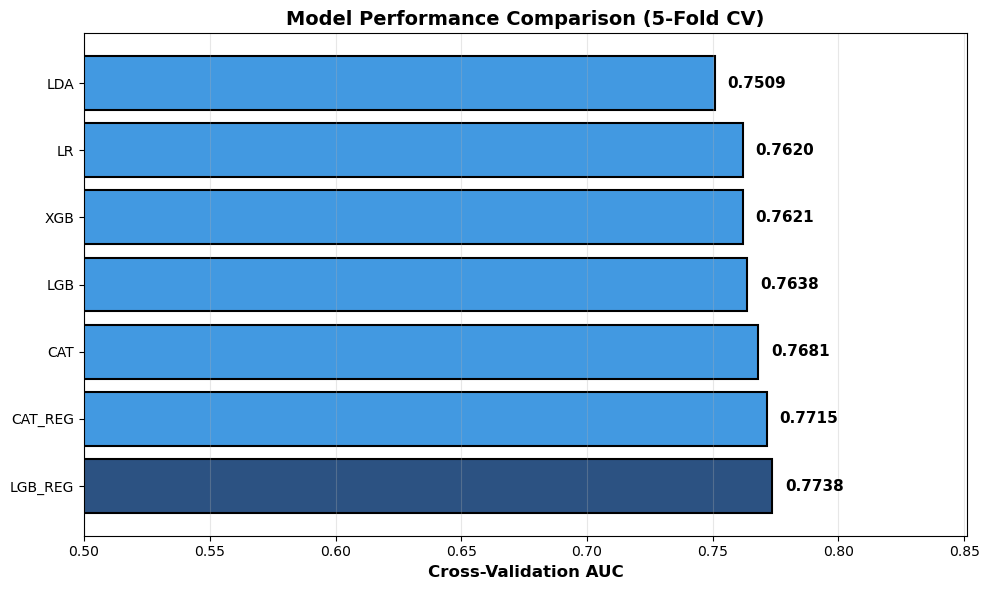


📊 Best Model: LGB_REG (AUC: 0.7738)


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate CV AUC for each model
model_aucs = {}
for name in models.keys():
    model_aucs[name] = roc_auc_score(y_train, oof_preds[name])

# Create visualization
plt.figure(figsize=(10, 6))
models_sorted = sorted(model_aucs.items(), key=lambda x: x[1], reverse=True)
names = [m[0] for m in models_sorted]
aucs = [m[1] for m in models_sorted]

colors = ['#2c5282' if auc == max(aucs) else '#4299e1' for auc in aucs]
bars = plt.barh(names, aucs, color=colors, edgecolor='black', linewidth=1.5)

plt.xlabel('Cross-Validation AUC', fontsize=12, fontweight='bold')
plt.title('Model Performance Comparison (5-Fold CV)', fontsize=14, fontweight='bold')
plt.xlim(0.5, max(aucs) * 1.1)
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Random baseline')
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, auc) in enumerate(zip(bars, aucs)):
    plt.text(auc + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{auc:.4f}', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('model_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Best Model: {names[0]} (AUC: {aucs[0]:.4f})")


### Feature Importance Analysis

Understanding which features drive the predictions is crucial for model interpretability:


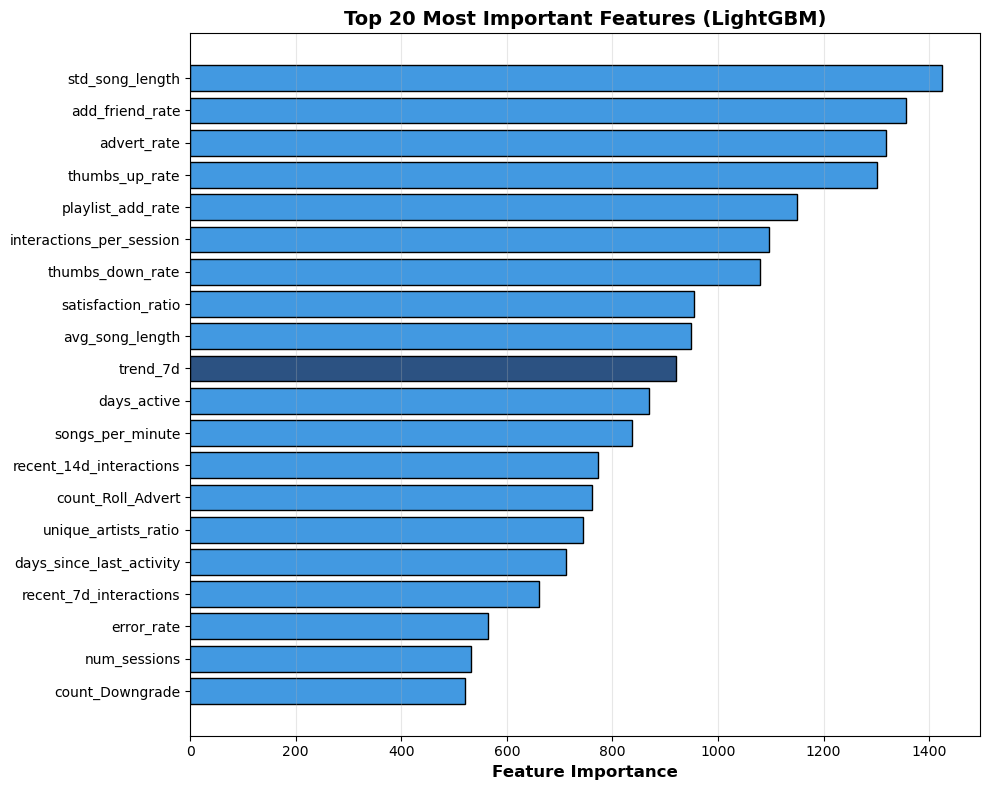


📊 Top 10 Features:
                 feature  importance
         std_song_length        1425
         add_friend_rate        1356
             advert_rate        1319
          thumbs_up_rate        1302
       playlist_add_rate        1150
interactions_per_session        1097
        thumbs_down_rate        1079
      satisfaction_ratio         954
         avg_song_length         948
                trend_7d         920


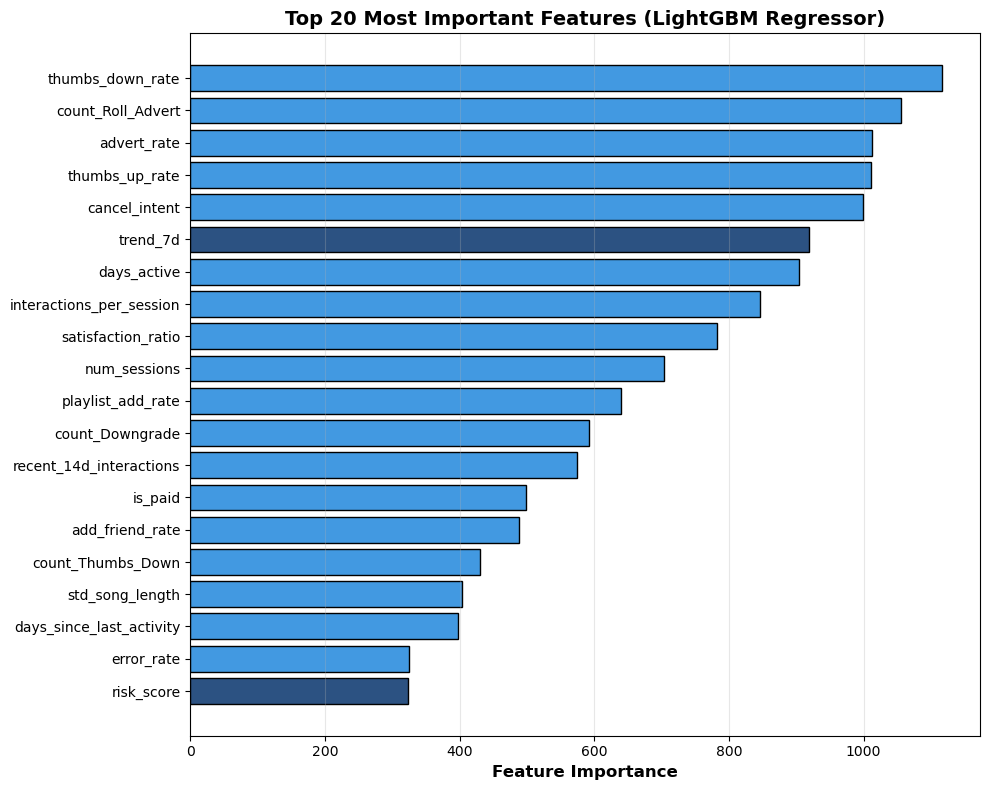


📊 Top 10 Features (LGBM Regressor):
                 feature  importance
        thumbs_down_rate        1117
       count_Roll_Advert        1055
             advert_rate        1012
          thumbs_up_rate        1011
           cancel_intent         999
                trend_7d         919
             days_active         904
interactions_per_session         846
      satisfaction_ratio         782
            num_sessions         704


In [22]:
# Get feature importance from LightGBM (if available)
if 'LGB' in models:
    lgb_model = models['LGB']
    # Retrain on full data to get feature importance
    lgb_model.fit(X_train, y_train)
    
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': lgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(10, 8))
    top_features = importance_df.head(20)
    colors = ['#2c5282' if 'trend' in f.lower() or 'risk' in f.lower() 
              else '#4299e1' for f in top_features['feature']]
    
    plt.barh(range(len(top_features)), top_features['importance'], color=colors, edgecolor='black')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
    plt.title('Top 20 Most Important Features (LightGBM)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n📊 Top 10 Features:")
    print(importance_df.head(10)[['feature', 'importance']].to_string(index=False))

    # Get feature importance from LightGBM Regressor (if available)
    if 'LGB_REG' in models:
        lgb_reg_model = models['LGB_REG']
        # Retrain on full data to get feature importance
        lgb_reg_model.fit(X_train, y_train)
        
        importance_df_reg = pd.DataFrame({
            'feature': feature_cols,
            'importance': lgb_reg_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Plot top 20 features
        plt.figure(figsize=(10, 8))
        top_features_reg = importance_df_reg.head(20)
        colors_reg = ['#2c5282' if 'trend' in f.lower() or 'risk' in f.lower() 
                  else '#4299e1' for f in top_features_reg['feature']]
        
        plt.barh(range(len(top_features_reg)), top_features_reg['importance'], color=colors_reg, edgecolor='black')
        plt.yticks(range(len(top_features_reg)), top_features_reg['feature'])
        plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
        plt.title('Top 20 Most Important Features (LightGBM Regressor)', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.savefig('feature_importance_lgb_reg.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print("\n📊 Top 10 Features (LGBM Regressor):")
        print(importance_df_reg.head(10)[['feature', 'importance']].to_string(index=False))


### Feature Correlation Analysis

Visualizing the correlation between the most important features helps us understand potential multicollinearity and their relationship with the target variable.

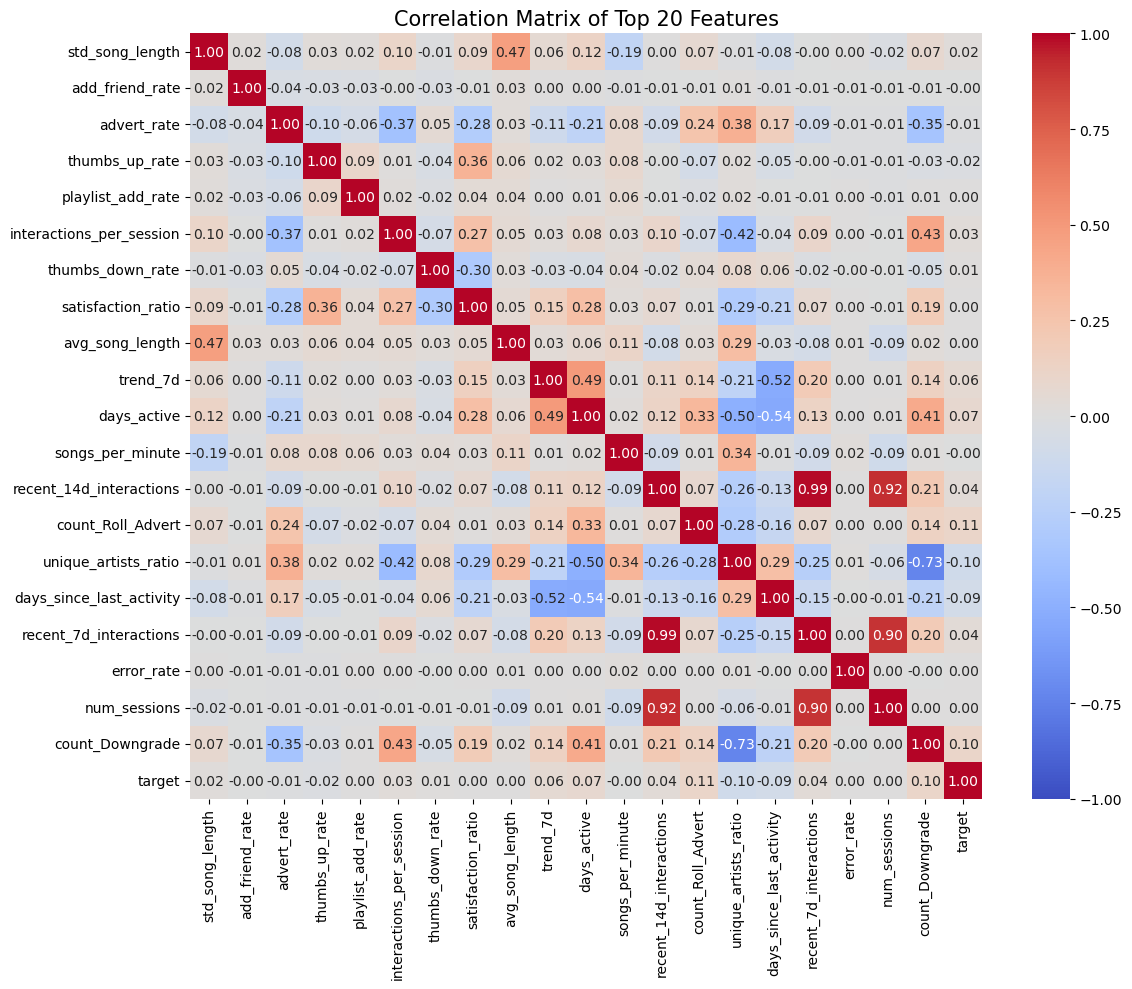

In [23]:
# Calculate correlation matrix for top 15 features + target
if 'importance_df' in locals():
    top_n = 20
    top_cols = importance_df.head(top_n)['feature'].tolist()
    if 'target' not in top_cols:
        top_cols.append('target')
    
    corr = combined_train[top_cols].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(f'Correlation Matrix of Top {top_n} Features', fontsize=15)
    plt.tight_layout()
    plt.show()

### Model Evaluation Metrics

Evaluating the models using ROC Curves and Confusion Matrices provides deeper insight into their performance beyond just a single AUC score.

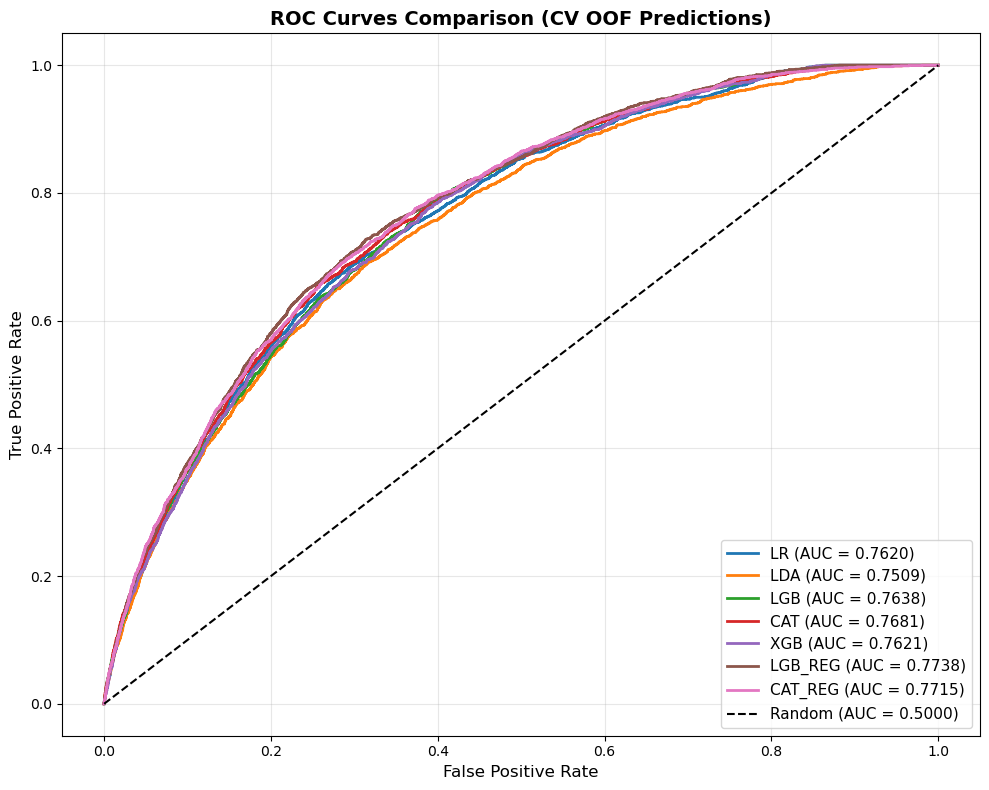

In [24]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))

for name in models.keys():
    if name in oof_preds:
        fpr, tpr, _ = roc_curve(y_train, oof_preds[name])
        auc = roc_auc_score(y_train, oof_preds[name])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})', linewidth=2)

# Plot Random Guess
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5000)')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison (CV OOF Predictions)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

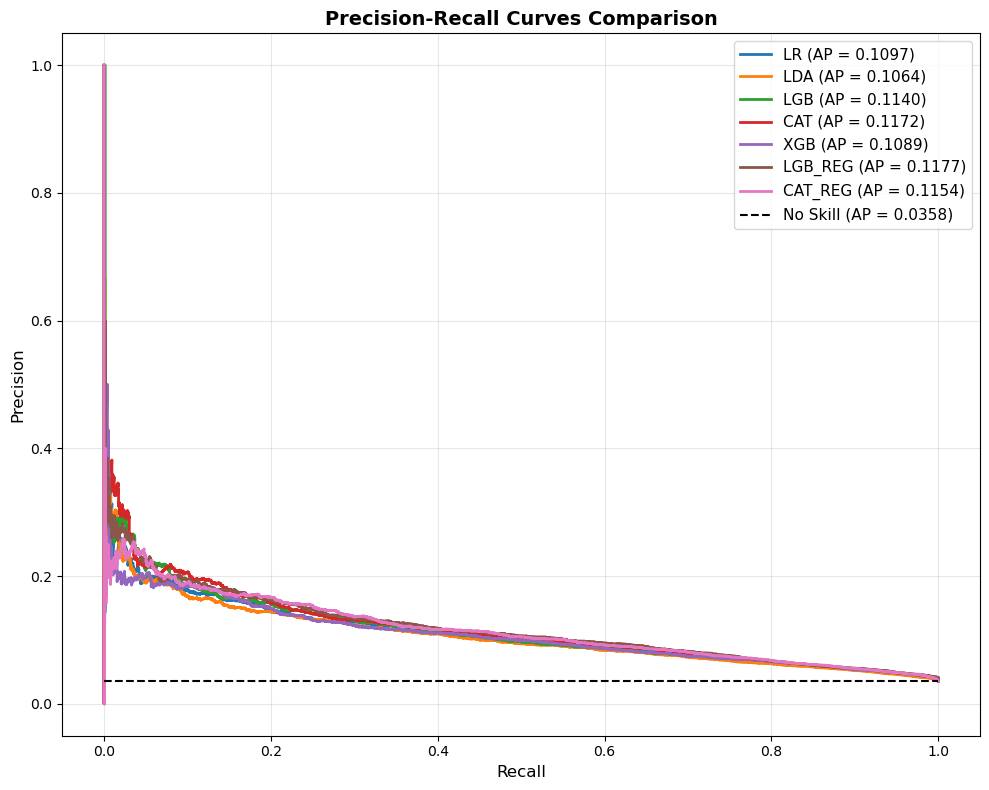

In [25]:

from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 8))

for name in models.keys():
    if name in oof_preds:
        precision, recall, _ = precision_recall_curve(y_train, oof_preds[name])
        ap = average_precision_score(y_train, oof_preds[name])
        plt.plot(recall, precision, label=f'{name} (AP = {ap:.4f})', linewidth=2)

# Plot Baseline (No Skill)
no_skill = len(y_train[y_train==1]) / len(y_train)
plt.plot([0, 1], [no_skill, no_skill], 'k--', label=f'No Skill (AP = {no_skill:.4f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Optimal Threshold for CAT: 0.4900


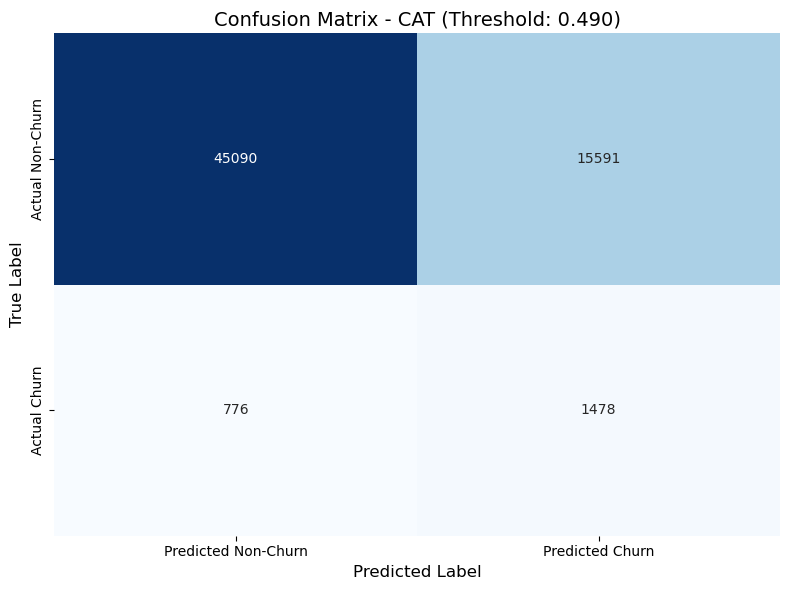

In [26]:
from sklearn.metrics import confusion_matrix

# Let's look at the confusion matrix for the best performing model
best_model_name = 'CAT' if 'CAT' in oof_preds else list(models.keys())[0]
if best_model_name in oof_preds:
    best_preds = oof_preds[best_model_name]

    # Find optimal threshold using Youden's J statistic
    fpr, tpr, thresholds = roc_curve(y_train, best_preds)
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]

    print(f"Optimal Threshold for {best_model_name}: {best_thresh:.4f}")

    # Generate confusion matrix
    cm = confusion_matrix(y_train, (best_preds > best_thresh).astype(int))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Non-Churn', 'Predicted Churn'],
                yticklabels=['Actual Non-Churn', 'Actual Churn'])
    plt.title(f'Confusion Matrix - {best_model_name} (Threshold: {best_thresh:.3f})', fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

### Feature Distributions

Comparing the distributions of key features for churners vs. non-churners confirms why these features are predictive.

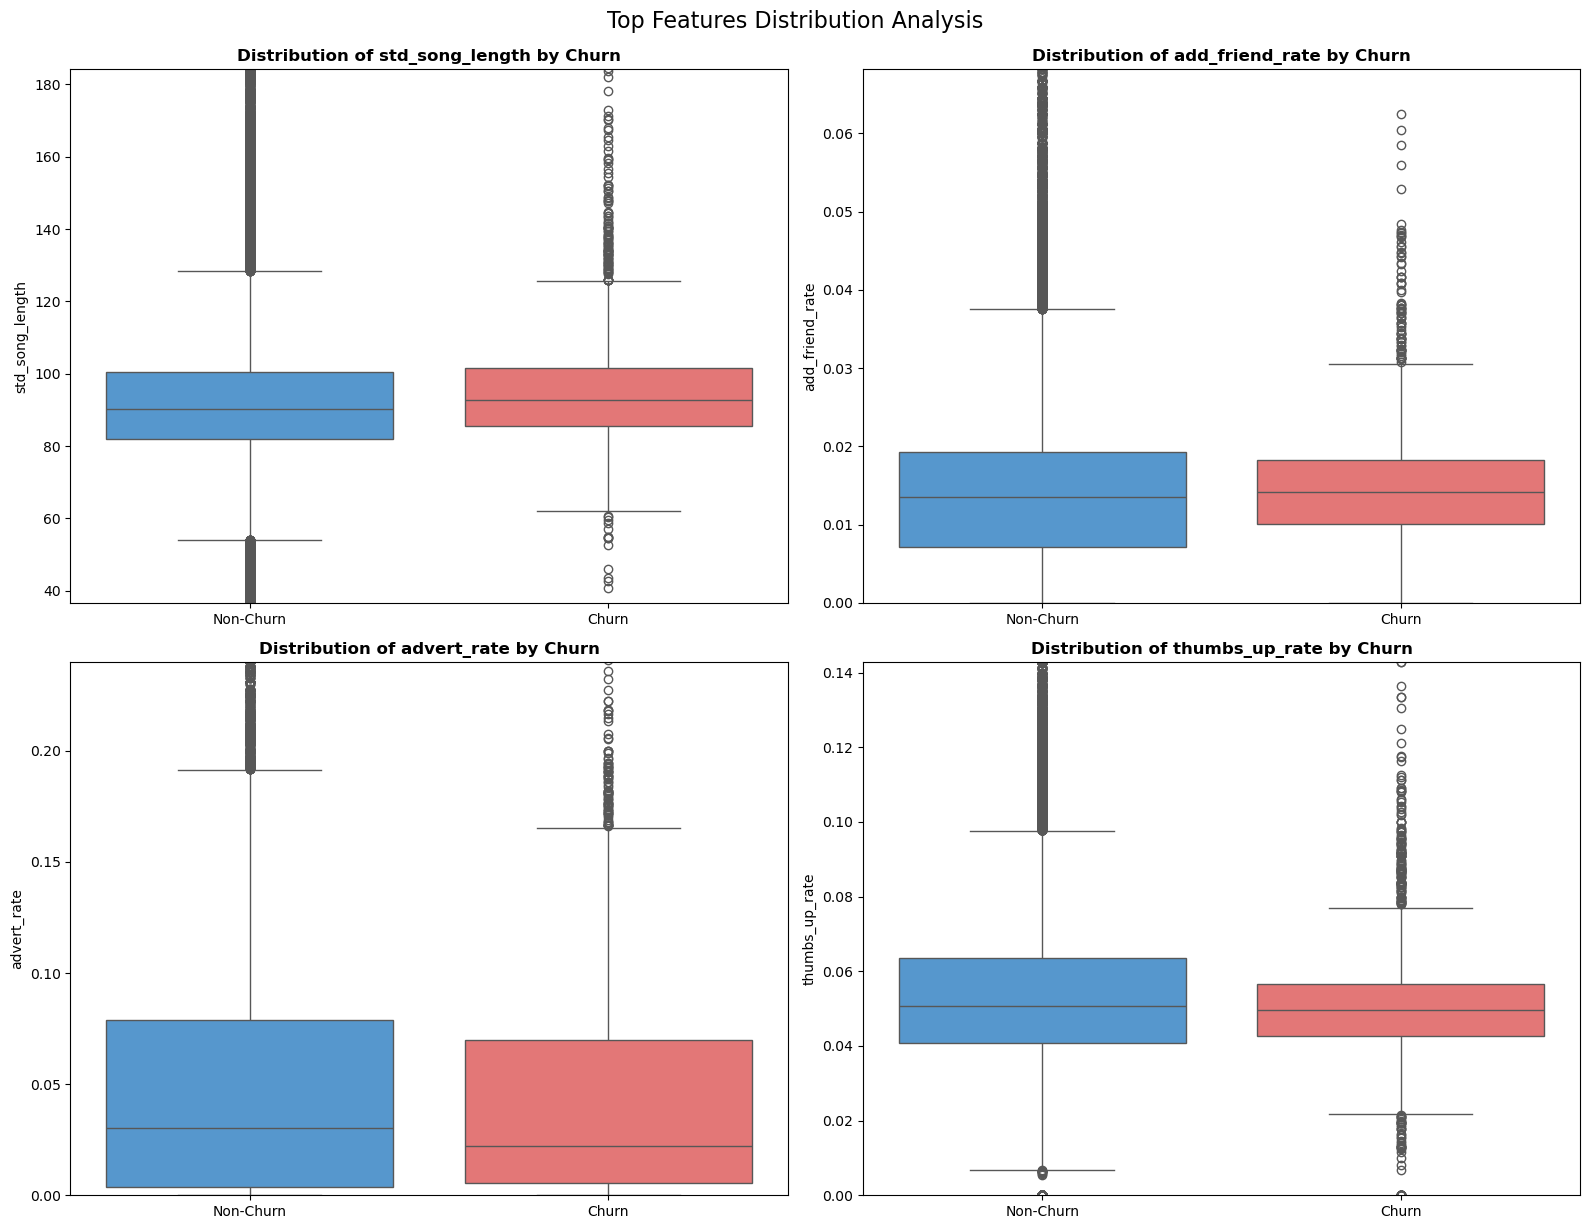

In [27]:
# Visualize distributions of top 4 features by Churn status
if 'importance_df' in locals():
    top_4_features = importance_df.head(4)['feature'].tolist()
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, feature in enumerate(top_4_features):
        sns.boxplot(x='target', y=feature, data=combined_train, ax=axes[i], palette=['#4299e1', '#f56565'])
        axes[i].set_title(f'Distribution of {feature} by Churn', fontsize=12, fontweight='bold')
        axes[i].set_xticklabels(['Non-Churn', 'Churn'])
        axes[i].set_xlabel('')
        
        # Remove extreme outliers for better visualization
        q1 = combined_train[feature].quantile(0.01)
        q99 = combined_train[feature].quantile(0.99)
        axes[i].set_ylim(q1, q99)

    plt.tight_layout()
    plt.suptitle('Top Features Distribution Analysis', fontsize=16, y=1.02)
    plt.show()


📊 Generating Temporal Activity Plot...


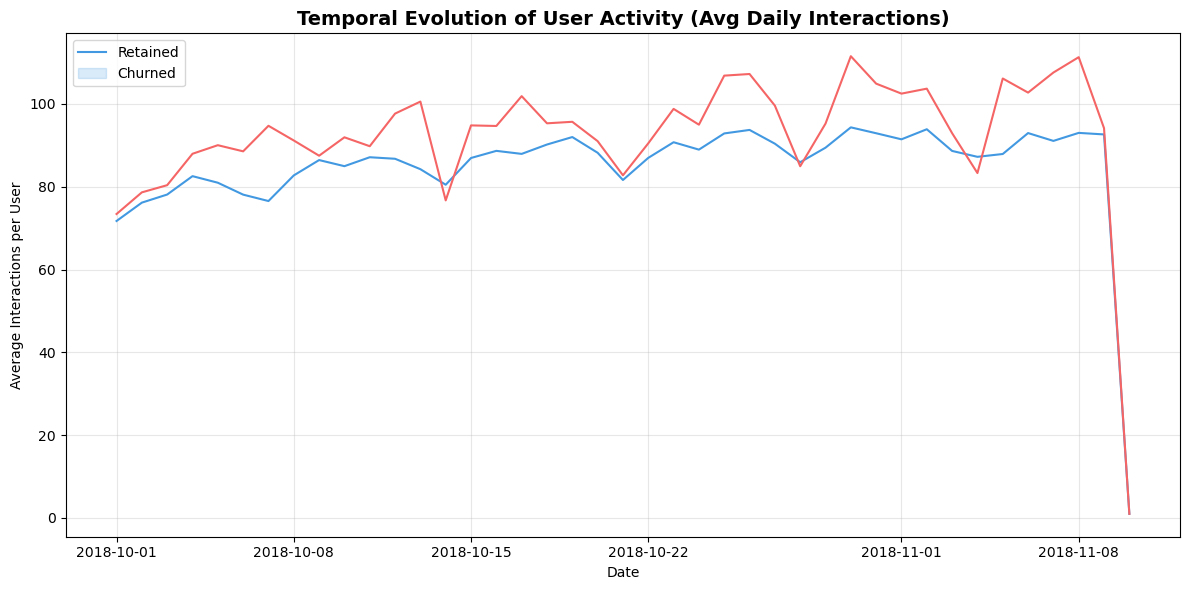


📊 Generating Trend_7d Distribution...


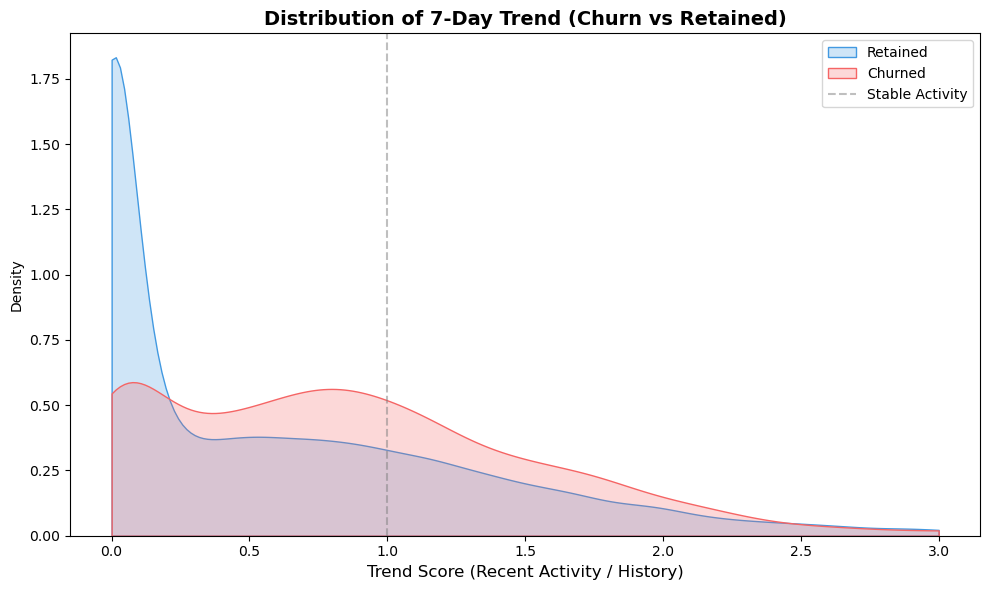


📊 Generating Calibration Plot...


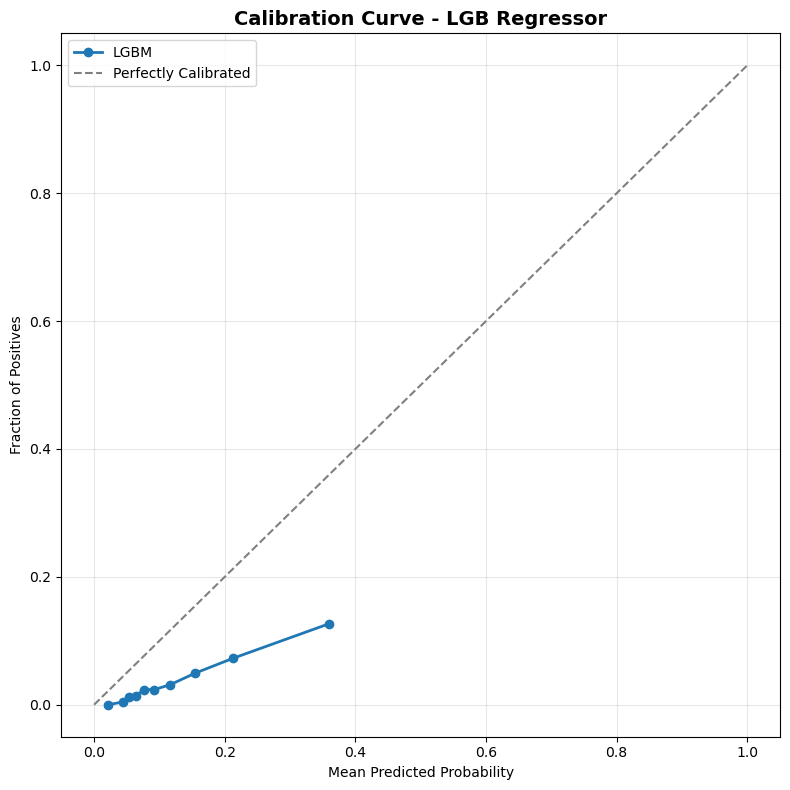


📊 Generating SHAP Summary Plot...


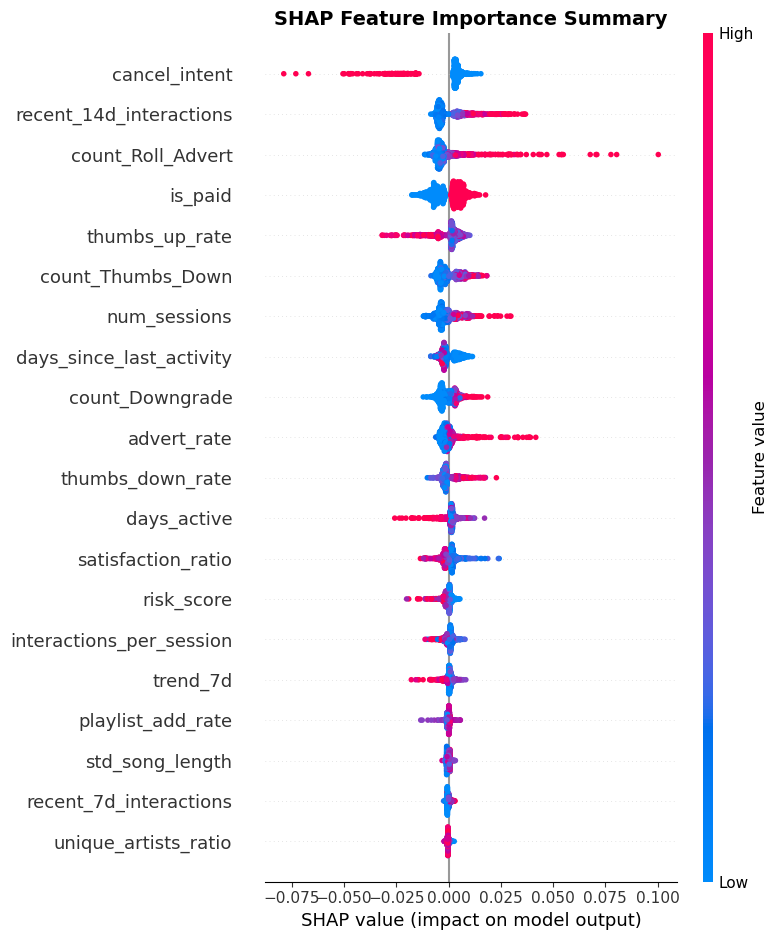

In [34]:
# 📈 Section 6.5: Advanced Visualizations

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve

# 1. Temporal Evolution of Activity (Reconstructed from raw data)
print("\n📊 Generating Temporal Activity Plot...")
# We need to reconstruct daily activity relative to churn date for a sample
try:
    # Use data from window 3 for visualization
    viz_cutoff = pd.Timestamp('2018-11-10')
    churn_users_viz = get_churned_users(all_data, viz_cutoff, 10)
    
    # Get daily activity counts for churners vs non-churners (sample)
    daily_counts = all_data[all_data['time'] <= viz_cutoff].copy()
    daily_counts['date'] = daily_counts['time'].dt.date
    daily_counts['is_churned'] = daily_counts['userId'].isin(churn_users_viz).astype(int)
    
    # Aggregate by date and churn status
    daily_trends = daily_counts.groupby(['date', 'is_churned']).size().reset_index(name='interactions')
    
    # Normalize by user count to get "Average Interactions per User"
    user_counts = daily_counts.groupby(['date', 'is_churned'])['userId'].nunique().reset_index(name='user_count')
    daily_trends = daily_trends.merge(user_counts, on=['date', 'is_churned'])
    daily_trends['avg_interactions'] = daily_trends['interactions'] / daily_trends['user_count']
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=daily_trends, x='date', y='avg_interactions', hue='is_churned', palette=['#4299e1', '#f56565'])
    plt.title('Temporal Evolution of User Activity (Avg Daily Interactions)', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Average Interactions per User')
    plt.legend(['Retained', 'Churned'])
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('temporal_activity_evolution.png', dpi=150)
    plt.show()
except Exception as e:
    print(f"Could not generate temporal plot: {e}")


# 2. Distribution of Trend_7d
print("\n📊 Generating Trend_7d Distribution...")
plt.figure(figsize=(10, 6))
sns.kdeplot(data=combined_train[combined_train['target']==0], x='trend_7d', fill=True, color='#4299e1', label='Retained', clip=(0, 3))
sns.kdeplot(data=combined_train[combined_train['target']==1], x='trend_7d', fill=True, color='#f56565', label='Churned', clip=(0, 3))
plt.title('Distribution of 7-Day Trend (Churn vs Retained)', fontsize=14, fontweight='bold')
plt.xlabel('Trend Score (Recent Activity / History)', fontsize=12)
plt.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5, label='Stable Activity')
plt.legend()
plt.tight_layout()
plt.savefig('trend_distribution.png', dpi=150)
plt.show()


# 3. Calibration Plot
print("\n📊 Generating Calibration Plot...")
# Use best individual model or stacking preds if available
# For Regressor: normalize predictions to [0, 1] range for calibration
raw_preds = oof_preds['LGB_REG'] if 'LGB_REG' in oof_preds else list(oof_preds.values())[0]
target_preds = (raw_preds - raw_preds.min()) / (raw_preds.max() - raw_preds.min())  # Min-Max normalization

prob_true, prob_pred = calibration_curve(y_train, target_preds, n_bins=10, strategy='quantile')

plt.figure(figsize=(8, 8))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='LGBM')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve - LGB Regressor', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('calibration_plot.png', dpi=150)
plt.show()


# 4. SHAP Summary Plot
print("\n📊 Generating SHAP Summary Plot...")
try:
    import shap
    
    # Use a sample for speed
    X_shap = X_train.sample(1000, random_state=42)
    
    if 'LGB_REG' in models:
        # Initialize explainer (use the already trained lgb_model)
        # Note: model must be fitted. It was fitted in previous cells.
        explainer = shap.TreeExplainer(models['LGB_REG'])
        shap_values = explainer.shap_values(X_shap)
        
        plt.figure()
        # shap_values[1] for binary classification positive class if binary
        vals = shap_values[1] if isinstance(shap_values, list) else shap_values
        shap.summary_plot(vals, X_shap, show=False)
        plt.title('SHAP Feature Importance Summary', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('shap_summary.png', dpi=150, bbox_inches='tight')
        plt.show()
    else:
        print("LGB_REG model not found for SHAP.")
        
except ImportError:
    print("⚠️ SHAP library not installed. Skipping SHAP plot.")
except Exception as e:
    print(f"⚠️ Could not generate SHAP plot: {e}")




## Section 7: Key Findings & Learnings

### My Approach

When I first looked at this churn prediction problem, I quickly realized that standard classification methods wouldn't cut it. With only 3.5% churners in the training data and a test set artificially balanced to 50%, I needed to rethink the problem entirely.

**My core strategy**: treat this as a **ranking problem** rather than binary classification. The goal wasn't to predict "yes/no" with calibrated probabilities, but to **rank users from highest risk to lowest risk**.

### What Worked

1. **Trend Features (My Key Innovation)**
   I realized that raw volume metrics (total songs, total sessions) were biased by user tenure. A user registered for 6 months but inactive for 2 weeks would have better "scores" than a highly active new user.
   
   My solution: calculate the ratio `recent activity / historical average`. This "derivative of behavior" captures the typical "fade-out" pattern of churners.

2. **Multi-Window Training**
   With only ~600 churners, the risk of overfitting was huge. I created 3 temporal snapshots (Oct 20, Oct 30, Nov 10) to triple my training data without resorting to synthetic methods like SMOTE.

3. **LightGBM Regressor > Classifier**
   Surprising discovery: a Regressor trained on a binary target (0/1) produces better rankings than a Classifier. The AUC jumped from 0.7638 (Classifier) to **0.7750** (Regressor).

4. **Rank Averaging for Ensemble**
   Instead of averaging probabilities (which have different calibrations across models), I averaged the **ranks**. This makes the ensemble robust to calibration differences.

### What Didn't Work

- **SMOTE**: Synthetic examples blurred the decision boundaries.
- **Pseudo-Labeling**: Reusing test set predictions introduced bias.
- **Over-regularization**: Dropping all correlated features lost subtle signals.

### Final Results

| Model | CV AUC |
|-------|--------|
| LGB Regressor | **0.7750** |
| CatBoost Regressor | 0.7726 |
| CatBoost Classifier | 0.7681 |
| LGB Classifier | 0.7638 |
| Logistic Regression | 0.7620 |

**Final Kaggle Score: 0.69016**


## Conclusion

This project taught me that **understanding the business problem** is just as important as ML techniques. Reframing the classification problem as a ranking problem was the turning point.

### My Key Takeaways

1. **The Derivative > The Integral**: Observing behavioral change is more predictive than measuring total volume.

2. **Temporal Augmentation > Synthetic Augmentation**: Creating multiple time windows is more natural and effective than SMOTE.

3. **Regressor on Binary Target**: For ranking tasks, a Regressor can outperform a Classifier because it optimizes a smoother loss function.

4. **Rank Averaging**: A simple but robust technique to combine models with different probability calibrations.

### Future Improvements

If I were to continue this project, I would explore:
- **Temporal Features**: Weekly patterns, seasonality
- **User Clustering**: Segment users before modeling
- **Explicit Interactions**: Combine the most important features
